In this notebook, we determine what fraction of events of a particular reaction have muon that enters the detector,
making the simplifying assumption that there is a uniform distribution of the particles' kinematics in the available phase space.
The reaction is $e p \rightarrow e'D_0\Lambda_c^+$ followed by $\Lambda_c^+\rightarrow\Lambda^0\bar\nu_\mu\mu^+$.  In principle,
the code used in this simplified event generator could be used for other reactions as well.  

The generation of three-particle events follows Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 .  

In [1]:
import ROOT, numpy as np, random, pandas as pd

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = [7.00, 5.00]
#presets for plot style
#from scipy.constants import golden
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=16)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('axes', labelsize=16)
rc('legend', fontsize=16)

import matplotlib.patches as patches

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Welcome to JupyROOT 6.27/01


In [2]:
rand = random.Random()

In [7]:
def oneToTwoGenerator():
    def __init__(self, m0, m1, m2):
        self.m1 = m1
        self.m2 = m2
        self.m0 = m0
        self.p = np.sqrt(m1**4+m2**4+m0**4-2*m1**2*m0**2-2*m1**2*m2**2-2*m0**2*m2**2)/(2*m0)
        self.E1 = np.hypot(m1, p) 
        self.E2 = np.hypot(m2, p)
    
    def next(self, P0):
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)
        
        p = self.p
        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, self.E1)
        P2 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, self.E2)
        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1,P2

 Use the formulas found here to get the 3-particle phase space:  Phys. Rev. D 86, 114023 (2012) https://arxiv.org/abs/1210.7939 

In [47]:
class oneToThreeGenerator():
    def __init__(self, m0, m1, m2, m3):
        self.m0 = m0
        self.x1 = (m1/self.m0)**2
        self.x2 = (m2/self.m0)**2
        self.x3 = (m3/self.m0)**2
        
        self.s13_min = (np.sqrt(self.x1)+np.sqrt(self.x3))**2
        self.s13_max =(1-np.sqrt(self.x2))**2
        print("s13 range:", self.s13_min, self.s13_max)
        self.s13s =np.linspace(self.s13_min,self.s13_max, 1000)[1:-1]
        self.pdf = np.sqrt(((1+self.x2-self.s13s)**2-4*self.x2)*((self.x1+self.x3-self.s13s)**2-4*self.x1*self.x3))/self.s13s
        self.pdf /= np.sum(self.pdf)
        self.cdf = [self.pdf[0]]
        for i in range(1,len(self.pdf)):
            self.cdf.append(self.cdf[-1]+self.pdf[i])
        
    def next(self, P0):
        
        #these are for particle 2:
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        #pdf of s13 is sqrt(((1+x2-s12)^2-4x^2)((x1+x3-s13)^2-4*x1*x3))/s13

        u = rand.uniform(0, 1)
        psum = 0
        s13= (self.s13_min+self.s13_max)/2
        found=False
        #TODO replace this with a binary search
        for i in range(len(self.cdf)):
            #print(psum)
            if(self.cdf[i]>u):
                s13=self.s13s[i]
                found = True
                break
        if not found:
            raise Exception("s13 not found in table")


        p2 = np.sqrt(s13**2 + self.x2**2+1 - 2*s13 - 2*s13*self.x2 - 2*self.x2)/2
        P2 = ROOT.TLorentzVector(p2*np.cos(phi)*sinTheta, p2*np.sin(phi)*sinTheta, p2*cosTheta, np.sqrt(self.x2+p2**2))


        p = np.sqrt(s13**2 + self.x3**2 + self.x1**2 - 2*self.x1*self.x3 - 2*s13*self.x3 - 2*s13*self.x1)/(2*np.sqrt(s13))

        #these are for particles 1, 3
        phi=rand.uniform(-np.pi, np.pi)
        cosTheta=rand.uniform(-1,1)
        sinTheta=np.sqrt(1-cosTheta**2)

        P1 = ROOT.TLorentzVector(p*np.cos(phi)*sinTheta, p*np.sin(phi)*sinTheta, p*cosTheta, np.sqrt(self.x1+p**2))
        P3 = ROOT.TLorentzVector(-p*np.cos(phi)*sinTheta, -p*np.sin(phi)*sinTheta, -p*cosTheta, np.sqrt(self.x3+p**2))


        boost = P2.Vect()#*(-1/np.sqrt(p2**2+s13))
        boost*=(-1/np.sqrt(p2**2+s13))

        P1.Boost(boost)
        P3.Boost(boost)

        beta = P0.BoostVector()
        P1.Boost(beta)
        P2.Boost(beta)
        P3.Boost(beta)
        #print((P0-P1-P2).M())
        #print((P0-P1-P2).E())
        return P1*self.m0,P2*self.m0,P3*self.m0

In [48]:
Ebeam=20
mp=.9383
mD0=1.86484
mLambdaC=2.2849
mLambda=1.115683
me=0.000511
mMu=0.1057

stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

P0=ROOT.TLorentzVector(0, 0, Ebeam,Ebeam+mp)
ep_to_d0_e_lambdac= oneToThreeGenerator(P0.M(), mD0, me, mLambdaC)
lambdac_decay = oneToThreeGenerator(mLambdaC, mLambda, 0, mMu)

s13 range: 0.4483015635264186 0.9998351088937868
s13 range: 0.2857388855110227 1.0


In [49]:
#now test the functions
P1, P2, P3 = ep_to_d0_e_lambdac.next(P0)
print("the following should be zero")
print("(P0-P1-P2-P3).P()", (P0-P1-P2-P3).P())
print("(P0-P1-P2-P3).E()", (P0-P1-P2-P3).E())
print("P1.M()-mD0", P1.M()-mD0)
print("P2.M()-me", P2.M()-me)
print("P3.M()-mLambdaC", P3.M()-mLambdaC)

the following should be zero
(P0-P1-P2-P3).P() 1.0660453750117863e-14
(P0-P1-P2-P3).E() 1.0658141036401503e-14
P1.M()-mD0 0.0
P2.M()-me 3.696519002352461e-13
P3.M()-mLambdaC -3.1086244689504383e-15


In [50]:
theta_mus=[]
d1 = {a+"_"+b:[] for a in "D0 e lambdac lambda numu mu".split() for b in "E px py pz p theta phi".split()}
for i in range(10000):
    d = {}
    d["D0"],d["e"],d["lambdac"] = ep_to_d0_e_lambdac.next(P0)
    d["lambda"],d["numu"],d["mu"] = lambdac_decay.next(d["lambdac"])
    for key in d.keys():
        d1[key + "_E"].append(d[key].E())
        d1[key + "_px"].append(d[key].Px())
        d1[key + "_py"].append(d[key].Py())
        d1[key + "_pz"].append(d[key].Pz())
        d1[key + "_p"].append(d[key].P())
        d1[key + "_theta"].append(d[key].Theta())
        d1[key + "_phi"].append(d[key].Phi())
df = pd.DataFrame(d1)

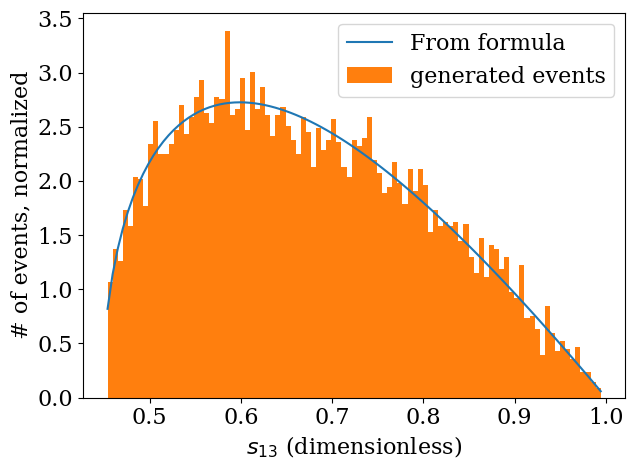

In [66]:
#check the distribution of the s13 variable

#show the pdf for the s13 variable
Ebeam=20
mD0=1.86484
mLambdaC=2.2849
mp = 0.9383
stot = (Ebeam+mp)**2-Ebeam**2
x1 = mD0**2/stot
x2 = 0.000511**2/stot
x3 = mLambdaC**2/stot

s13_min = (np.sqrt(x1)+np.sqrt(x3))**2
s13_max =(1-np.sqrt(x2))**2
s13 =np.linspace(s13_min,s13_max, 100)[1:-1]
binwidth=s13[1]-s13[0]
pdf = np.sqrt(((1+x2-s13)**2-4*x2)*((x1+x3-s13)**2-4*x1*x3))/s13
pdf /=sum(pdf)*binwidth
plt.plot(s13, pdf, label="From formula")

plt.hist(df.eval(f"((D0_E+lambdac_E)**2-(D0_px+lambdac_px)**2-(D0_py+lambdac_py)**2-(D0_pz+lambdac_pz)**2)/{P0.M()**2}"), bins=s13,density = True, label="generated events")
plt.legend()
plt.xlabel("$s_{13}$ (dimensionless)")
plt.ylabel("# of events, normalized")
plt.show()

0.1705 +- 0.003760714692714671


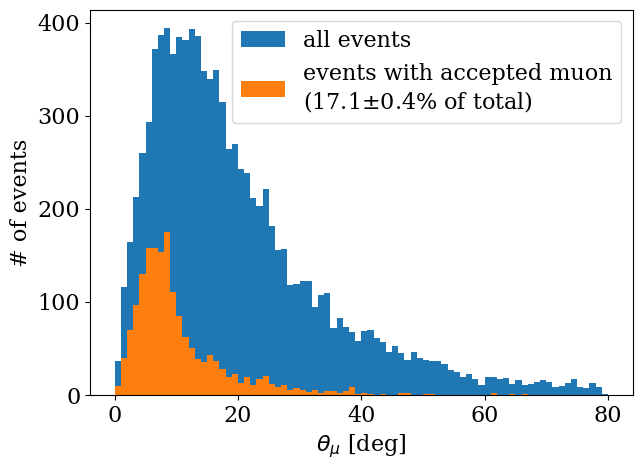

In [65]:
#what fraction of the events have a muon that enters the acceptance of the fcal?
#plot the theta distribution of the accepted events and all events.
z_front = 1300
detector_length=300
detector_ymin = -220
detector_ymax = -8
uxmax = (detector_length/2)/z_front
uymin = detector_ymin/z_front
uymax = detector_ymax/z_front

accepted = df.query(f"mu_px/mu_pz<{uxmax} and mu_py/mu_pz>{uymin} and mu_py/mu_pz<{uymax}")
num = len(accepted)
denom = len(df)
print(num/denom, "+-", np.sqrt(num*(denom-num)/denom**3))


plt.hist(df.mu_theta*180/np.pi,bins=np.linspace(0,80,81), label ="all events")
plt.hist(accepted.mu_theta*180/np.pi,bins=np.linspace(0, 80, 81), label=f"events with accepted muon\n({num/denom*100:.1f}$\pm${np.sqrt(num*(denom-num)/denom**3)*100:.1f}% of total)")
plt.legend()
plt.xlabel("$\\theta_\mu$ [deg]")
plt.ylabel("# of events")
plt.show()